<h1 style="text-align: center;">Final Project</h1>
<h2 style="text-align: center;">02807 Computational Tools for Data Science</h2>
<p style="text-align: center;">Authors: s241645, s242689, s253167, s253095</p>

## 1. Introduction

Credit card fraud is rare, only about 0.2% of transactions in the dataset are fraudulent. This makes it difficult to train a model to recognize fraud directly, since there are so few examples to learn from.

Instead, we take an anomaly detection approach: we train a model to learn what normal transactions look like. Transactions that don't fit this learned pattern are flagged as potential fraud.

**Method:**
1. Cluster normal transactions using K-Means
2. Train a separate AutoEncoder for each cluster
3. Classify transactions with high reconstruction error as fraudulent

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, davies_bouldin_score
import torch
import torch.nn.functional as F
import random

import sys, os
sys.path.append(os.path.abspath('..'))

from src.data import load_scaler
from src.cluster import load_kmeans_model
from src.model import AutoEncoder
from src.eval import compute_reconstruction_errors, find_optimal_threshold, calculate_metrics

## 2. Data Overview

The dataset contains credit card transactions from European cardholders in September 2013. Features V1-V28 are PCA-transformed (for privacy), while `Time` and `Amount` are original features.

In [5]:
df = pd.read_csv('../data/creditcard.csv')
print(f"Shape: {df.shape}")
print(f"Features: {df.columns.tolist()}")

fraud_count = df['Class'].sum()
normal_count = len(df) - fraud_count

print(f"Normal transactions: {normal_count} ({100 * normal_count / len(df):.2f}%)")
print(f"Fraudulent transactions: {fraud_count} ({100 * fraud_count / len(df):.2f}%)")

df.describe() # quick overview of the data

Shape: (284807, 31)
Features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Normal transactions: 284315 (99.83%)
Fraudulent transactions: 492 (0.17%)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## 3. Data Preprocessing

We split the data into two sets:
- **Base data**: Normal transactions only — used to train the AutoEncoders
- **Tune data**: All fraud + a sample of normal — used to find optimal thresholds and evaluate

We also standardize features using `StandardScaler` fitted only on normal data.

In [8]:
base_df = pd.read_csv('../data/base_data.csv')
tune_df = pd.read_csv('../data/tune_data.csv')

print("Base data (training):")
print(f"  {len(base_df)} samples, {base_df['Class'].sum()} fraud")

print("\nTune data (threshold tuning + evaluation):")
print(f"  {len(tune_df)} samples, {tune_df['Class'].sum()} fraud")

# Load pre-fitted scaler (fitted on normal data only)
X_base = base_df.drop(columns=['Class'])
scaler = load_scaler()
X_base_scaled = scaler.transform(X_base)

print(f"Before scaling - Mean: {X_base.values.mean():.2f}, Std: {X_base.values.std():.2f}")
print(f"After scaling  - Mean: {X_base_scaled.mean():.2f}, Std: {X_base_scaled.std():.2f}")

Base data (training):
  282347 samples, 0 fraud

Tune data (threshold tuning + evaluation):
  2460 samples, 492 fraud
Before scaling - Mean: 3164.23, Std: 19103.81
After scaling  - Mean: 0.00, Std: 1.00


/Users/sunna/Desktop/dtu/year2/autumn/Data Science/project/.venv/lib/python3.14/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 4. Clustering
Normal transactions aren't uniform because of different spending patterns, amounts, times, etc. Rather than training one model on all data, we cluster similar transactions and train a specific AutoEncoder on each cluster.

### 4.1 K-Means Implementation
We implemented the K-Means algorithm ourselves:

In [11]:
def kmeans_implementation(X, k, max_iters=300, tol=0.0001, random_state=42) -> tuple[np.ndarray, np.ndarray]:
    """
    A simple implementation of the K-means clustering algorithm.
    Parameters:
    - X: Input data, scaled numpy array of shape (n_samples, n_features).
    - k: Number of clusters.
    - max_iters: Maximum number of iterations.
    - tol: Tolerance to declare convergence.
    - random_state: Seed for reproducibility.
    """

    if random_state is not None:
        random.seed(random_state)
        np.random.seed(random_state)

    data = np.asarray(X)
    n_samples, n_features = data.shape

    # Randomly choose initial centroids
    indices = np.random.choice(n_samples, k, replace=False)
    centroids = data[indices, :]

    for iteration in range(max_iters):
        # Assign points to nearest centroid
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            points = data[labels == i]
            if len(points) > 0:
                new_centroids[i] = points.mean(axis=0)
            else:
                # Reinitialize empty cluster randomly
                new_centroids[i] = data[np.random.randint(0, n_samples)]

        # Check for convergence
        shift = np.linalg.norm(new_centroids - centroids)
        if shift < tol:
            print(f"Converged after {iteration+1} iterations.")
            break

        centroids = new_centroids

    return labels, centroids

class OurKmeans:
    def __init__(self, centroids: np.ndarray):
        self.centroids = centroids  # shape: (k, n_features)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Assign each row in X to the nearest centroid."""
        X = np.asarray(X)
        distances = np.linalg.norm(X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :], axis=2)
        return np.argmin(distances, axis=1)

### 4.2 Choosing K
We use two methods to determine the optimal number of clusters:
- **Elbow method**: Look for the "elbow" where inertia stops decreasing significantly
- **Davies-Bouldin index**: Lower values indicate better-defined clusters

Converged after 21 iterations.
Converged after 26 iterations.
Converged after 29 iterations.
Converged after 43 iterations.
Converged after 33 iterations.
Converged after 37 iterations.
Converged after 37 iterations.
Converged after 39 iterations.
Converged after 41 iterations.


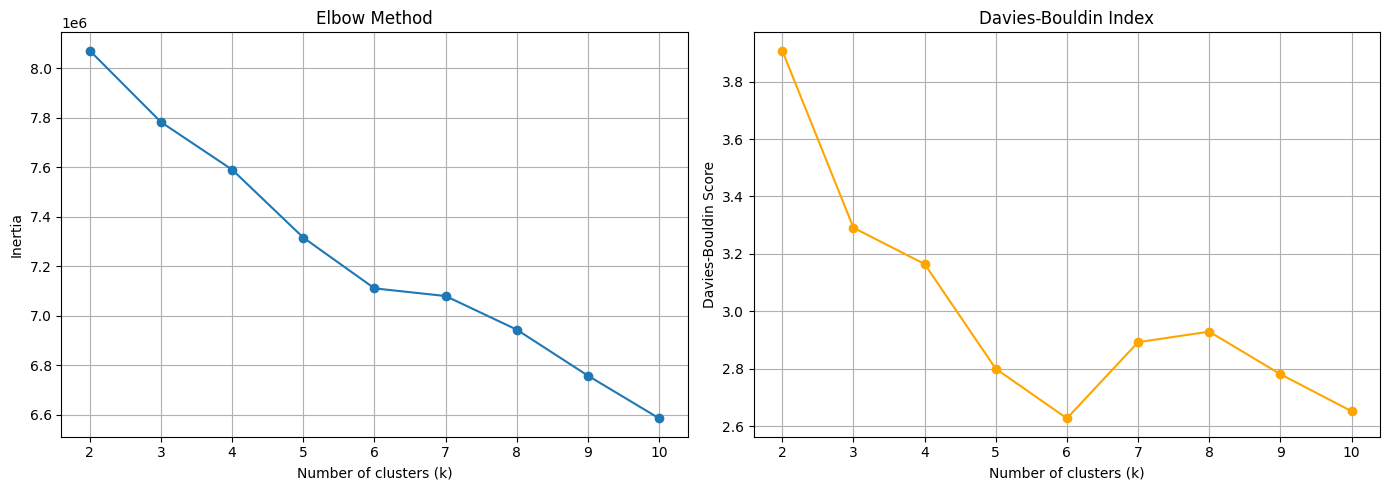

In [13]:
def compute_inertia(data, labels, centroids):
    if hasattr(data, 'to_numpy'):
        data = data.to_numpy()
    inertia = 0.0
    for i, point in enumerate(data):
        inertia += np.sum((point - centroids[labels[i]]) ** 2)
    return inertia

inertias = []
db_scores = []
k_range = range(2, 11)

for k in k_range:
    labels, centroids = kmeans_implementation(X_base_scaled, k)
    inertias.append(compute_inertia(X_base_scaled, labels, centroids))
    db_scores.append(davies_bouldin_score(X_base_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertias, marker='o')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

axes[1].plot(k_range, db_scores, marker='o', color='orange')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Davies-Bouldin Score')
axes[1].set_title('Davies-Bouldin Index')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### 4.3 Clustering Normal Transactions
With K=4 selected based on the elbow method and Davies-Bouldin index, we apply K-Means to segment the normal transactions. (kannski aðeins að henda betri rökstuðningi hingað..?)

In [15]:
K = 4
cluster_labels, centroids = kmeans_implementation(X_base_scaled, k=K, random_state=42)
kmeans = OurKmeans(centroids=centroids) # for future predictions

print("Cluster distribution:")
for i in range(K):
    count = (cluster_labels == i).sum()
    pct = count / len(cluster_labels) * 100
    print(f"  Cluster {i}: {count:,} samples ({pct:.1f}%)")

Converged after 29 iterations.
Cluster distribution:
  Cluster 0: 33,591 samples (11.9%)
  Cluster 1: 19,755 samples (7.0%)
  Cluster 2: 137,615 samples (48.7%)
  Cluster 3: 91,386 samples (32.4%)


### 4.4 Cluster Visualization

We use PCA to project the high-dimensional data into 2D and 3D for visualization.

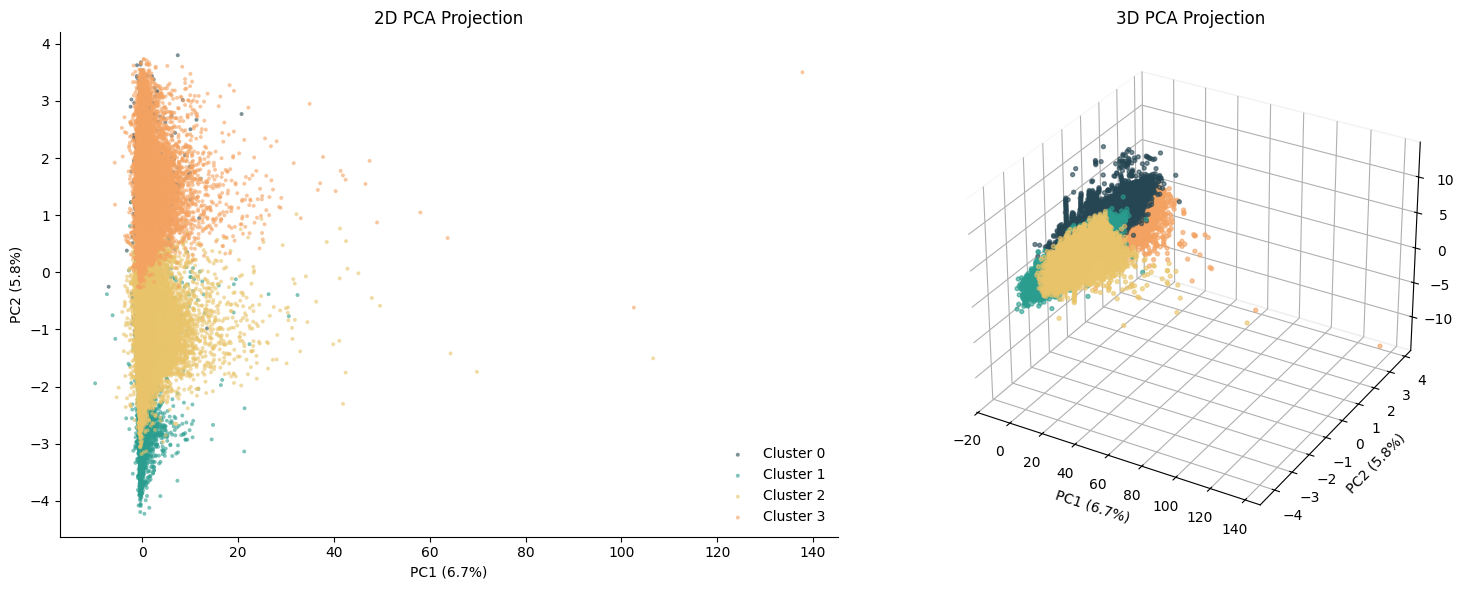

In [ ]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_base_scaled)
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_base_scaled)
colors = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261']
fig = plt.figure(figsize=(16, 6))

# 2D plot
ax1 = fig.add_subplot(121)
for i in range(K):
    mask = cluster_labels == i
    ax1.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], c=colors[i], label=f'Cluster {i}', alpha=0.6, s=8, edgecolors='none')

ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
ax1.set_title('2D PCA Projection')
ax1.legend(frameon=False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# 3D plot
ax2 = fig.add_subplot(122, projection='3d')
for i in range(K):
    mask = cluster_labels == i
    ax2.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2], c=colors[i], label=f'Cluster {i}', alpha=0.6, s=8)

ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)')
ax2.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)')
ax2.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)')
ax2.set_title('3D PCA Projection')
ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False

plt.tight_layout()
plt.show()